# Pre-processing of UNSW Dataset

Pre-processing UNSW dataset, cleaning and handling values discrepancies. All four CSV files are combined and processed before exporting it to combined CSV file.

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import hashlib as hl
import csv
from os import close
import numpy as np
import logging
import argparse
import sys
from datetime import datetime
import socket
import math
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import pickle as pkl
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import ClusterCentroids 
%matplotlib inline

In [76]:
# Reading of all 4 csv files of UNSW
dfs = []
for i in range(1,5):
    path = 'E:/UNSW-NB15 Dataset/UNSW-NB15-CSV-Files/UNSW-NB15_{}.csv'  # There are 4 input csv files
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)

# Adding Column names to the CSV file
df_col = pd.read_csv('E:/UNSW-NB15 Dataset/UNSW-NB15-CSV-Files/NUSW-NB15_features.csv', encoding='ISO-8859-1')
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())
all_data.columns = df_col['Name']
print(all_data.shape)

C:\Users\yasir.ali\AppData\Local\Temp\ipykernel_9724\2116226758.py:5: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header = None))
C:\Users\yasir.ali\AppData\Local\Temp\ipykernel_9724\2116226758.py:5: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header = None))


(2540047, 49)


In [3]:
# Exploring Data for missing Values
all_data.isnull().sum() # attack_cat has no label for normal data instances
                        # ct_flw_http_mthd & is_ftp_login has missing values

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

In [7]:
# Replacing Missing value with normal in attack_cat column. Moreover, removing adddtional spaces and converting labels to lower case
all_data['attack_cat'] = all_data.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

In [9]:
# Instead of removing the rows having missing value, here we have removed these two columns
all_data.drop(columns=['ct_flw_http_mthd', 'is_ftp_login'],inplace=True)

In [10]:
all_data.isnull().values.any()
# No more missing value

False

In [11]:
all_data.isin([np.inf, -np.inf]).values.sum()
# No inf data instances

0

In [5]:
all_data['attack_cat'].value_counts() # Inconsistency in Attack labels

Generic             215481
Exploits             44525
 Fuzzers             19195
DoS                  16353
 Reconnaissance      12228
 Fuzzers              5051
Analysis              2677
Backdoor              1795
Reconnaissance        1759
 Shellcode            1288
Backdoors              534
Shellcode              223
Worms                  174
Name: attack_cat, dtype: int64

In [12]:
all_data['attack_cat'] = all_data['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

In [13]:
all_data['attack_cat'].value_counts()

normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             2329
shellcode            1511
worms                 174
Name: attack_cat, dtype: int64

In [14]:
all_data['service'].value_counts()

-           1246397
dns          781668
http         206273
ftp-data     125783
smtp          81645
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: service, dtype: int64

In [15]:
# removing all the "-" and replacing those with "None"
all_data['service'] = all_data['service'].apply(lambda x:"None" if x=="-" else x)

In [22]:
all_data.ct_ftp_cmd.unique()

array([0, 1, 6, 2, 4, 8, 5, 3])

In [21]:
all_data['ct_ftp_cmd'] = all_data['ct_ftp_cmd'].apply(lambda x:0 if x==" " else x).astype(int)
## One or more values are in string, converting to int

In [25]:
all_data.shape

(2540047, 47)

In [26]:
df = all_data[all_data.duplicated(keep=False)]
## Checking Duplicate Values

In [33]:
df.shape

(568838, 47)

In [30]:
df

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
7,10.40.182.3,0,10.40.182.3,0,arp,INT,0.000000,46,0,0,...,0,2,2,2,2,2,2,2,normal,0
10,10.40.170.2,0,10.40.170.2,0,arp,INT,0.000000,46,0,0,...,0,2,2,2,2,2,2,2,normal,0
11,10.40.170.2,0,10.40.170.2,0,arp,INT,0.000000,46,0,0,...,0,2,2,2,2,2,2,2,normal,0
12,10.40.182.3,0,10.40.182.3,0,arp,INT,0.000000,46,0,0,...,0,2,2,2,2,2,2,2,normal,0
70,59.166.0.6,15807,149.171.126.7,53,udp,CON,0.001118,132,164,31,...,0,12,8,5,3,3,2,2,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540034,59.166.0.7,20848,149.171.126.4,21,tcp,CON,0.365058,456,346,31,...,2,2,2,2,2,2,2,2,normal,0
2540035,59.166.0.5,53521,149.171.126.7,21,tcp,CON,1.086072,1940,2404,31,...,2,2,2,3,3,2,2,3,normal,0
2540040,59.166.0.9,61886,149.171.126.1,21,tcp,CON,3.108071,1148,1402,31,...,2,2,2,2,4,2,2,3,normal,0
2540043,59.166.0.7,20848,149.171.126.4,21,tcp,CON,0.365058,456,346,31,...,2,2,2,2,2,2,2,2,normal,0


In [31]:
all_data.loc[7,:]

Name
srcip               10.40.182.3
sport                         0
dstip               10.40.182.3
dsport                        0
proto                       arp
state                       INT
dur                         0.0
sbytes                       46
dbytes                        0
sttl                          0
dttl                          0
sloss                         0
dloss                         0
service                    None
sload                       0.0
dload                       0.0
spkts                         1
dpkts                         0
swin                          0
dwin                          0
stcpb                         0
dtcpb                         0
smeansz                      46
dmeansz                       0
trans_depth                   0
res_bdy_len                   0
sjit                        0.0
djit                        0.0
stime                1421927415
ltime                1421927415
sintpkt                     0.0
din

In [32]:
all_data.loc[12,:]

Name
srcip               10.40.182.3
sport                         0
dstip               10.40.182.3
dsport                        0
proto                       arp
state                       INT
dur                         0.0
sbytes                       46
dbytes                        0
sttl                          0
dttl                          0
sloss                         0
dloss                         0
service                    None
sload                       0.0
dload                       0.0
spkts                         1
dpkts                         0
swin                          0
dwin                          0
stcpb                         0
dtcpb                         0
smeansz                      46
dmeansz                       0
trans_depth                   0
res_bdy_len                   0
sjit                        0.0
djit                        0.0
stime                1421927415
ltime                1421927415
sintpkt                     0.0
din

In [36]:
all_data.drop_duplicates(inplace=True)
all_data.shape

(2059417, 47)

In [37]:
all_data.to_csv('E:/UNSW-NB15 Dataset/UNSW-NB15-CSV-Files/Preprocessed-CSV/UNSW-NB15_processed.csv', index=False)

In [ ]:
saved_dict = {}
saved_dict['columns'] = df_col['Name'][df_col['Name']!='label'].tolist()
saved_dict['binary_col'] = ['is_sm_ips_ports', 'is_ftp_login']

In [167]:
all_data.proto.value_counts()

tcp     1448858
udp      588027
arp        6658
unas       4765
ospf       3964
         ...   
tp++         46
ib           46
udt           8
rtp           7
esp           2
Name: proto, Length: 135, dtype: int64

In [5]:
df.service.unique()

array(['dns', 'None', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3',
       'snmp', 'ssl', 'irc', 'radius', 'dhcp'], dtype=object)

In [52]:
df.attack_cat.unique()

array(['normal', 'exploits', 'reconnaissance', 'dos', 'generic',
       'shellcode', 'fuzzers', 'worms', 'backdoor', 'analysis'],
      dtype=object)

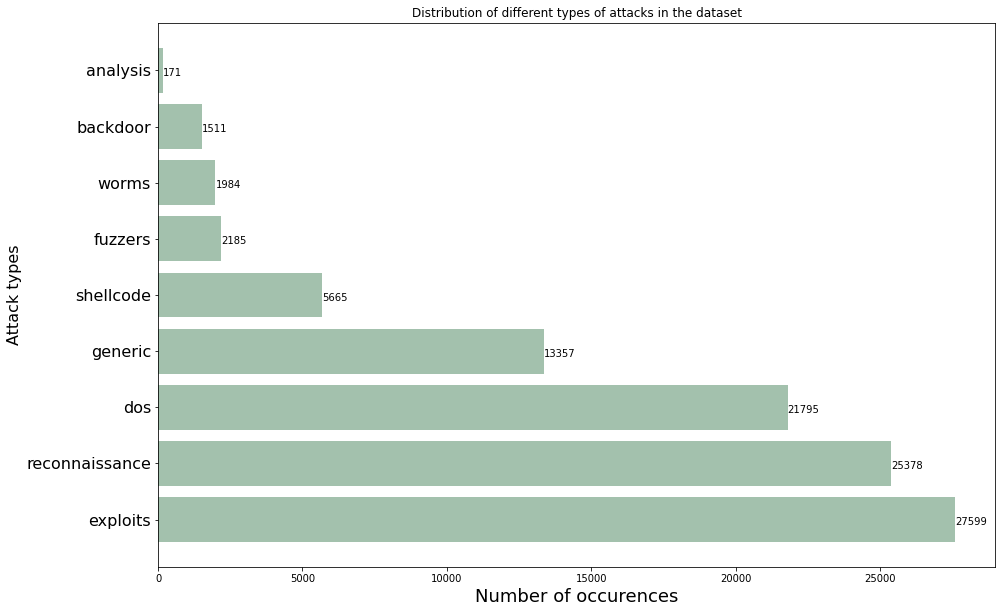

In [74]:
plt.figure(figsize=(15,10))

attack = ( 'exploits', 'reconnaissance', 'dos', 'generic',
       'shellcode', 'fuzzers', 'worms', 'backdoor', 'analysis')
y_pos = np.arange(len(attack)) 
amount = df['attack_cat'].value_counts()[1:]
plt.barh(y_pos, amount, align='center', color='#a3c1ad' )
plt.yticks(y_pos, attack,fontsize=16)
plt.title('Distribution of different types of attacks in the dataset')
plt.xlabel('Number of occurences',fontsize=18)
plt.ylabel('Attack types',fontsize=16)
for i, v in enumerate(amount):
    plt.text(v + 3, i-0.1 , str(v))
    
plt.show()

## Handling protocol Values

In [18]:
df_p=pd.read_csv("E:/UNSW-NB15 Dataset/UNSW-NB15-CSV-Files/Preprocessed-CSV/UNSW-NB15_processed.csv")
df_p=df_p[['stime','ltime','srcip','dstip','dsport','sport','sttl','proto','dur','attack_cat','label']]

In [10]:
Important_protocol=df_p.proto[df_p.label==1].value_counts()

In [12]:
Important_protocol

tcp          9830
udp          4543
unas          535
ospf          114
sctp           46
             ... 
idrp            5
il              5
idpr-cmtp       5
ddp             5
ib              5
Name: proto, Length: 128, dtype: int64

In [14]:
b=Important_protocol.keys()[30:]
b=b.drop('fire')
b=b.drop('sccopmce')
b=b.drop('crtp')
b=b.drop('crudp')
b=b.drop('iplt')
b=b.drop('sps')
b=b.drop('pipe')
b=b.drop('fc')
b=b.drop('ib')
b=b.drop('ggp')
b=b.drop('egp')
b=b.drop('hmp')
b=b.drop('rdp')

## Some Additional Protocol to retain

In [15]:
df_p['proto'].replace(b,'others',inplace=True)

In [19]:
df_p.proto.value_counts() ### We have only considered the top 30 protocols and rest are being labelled as others
                          ### Same is done in the parser(built for getting information from pcap files)

tcp            752033
udp            289943
arp              3419
ospf             1735
unas              535
others            490
icmp              154
sctp               46
any                15
gre                14
vmtp               10
ip                 10
igmp               10
emcon              10
nvp                10
snp                10
secure-vmtp        10
rsvp               10
sep                 9
pim                 9
mobile              9
sun-nd              9
swipe               9
ipv6                8
leaf-2              7
dgp                 5
ipip                5
micp                5
aes-sp3-d           5
encap               5
etherip             5
pri-enc             5
gmtp                5
pnni                5
udt                 4
esp                 2
Name: proto, dtype: int64

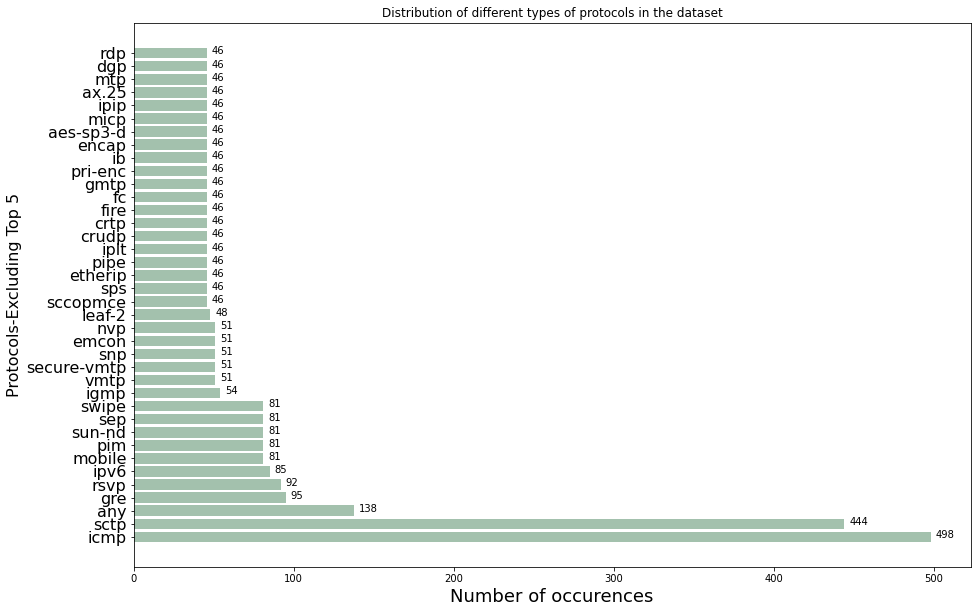

In [21]:
plt.figure(figsize=(15,10))

attack=df_p.proto.value_counts().keys()[6:-6]
y_pos = np.arange(len(attack)) 
amount = df_p['proto'].value_counts()[6:-6]
plt.barh(y_pos, amount, align='center', color='#a3c1ad' )
plt.yticks(y_pos, attack,fontsize=16)
plt.title('Distribution of different types of protocols in the dataset')
plt.xlabel('Number of occurences',fontsize=18)
plt.ylabel('Protocols-Excluding Top 5',fontsize=16)
for i, v in enumerate(amount):
    plt.text(v + 3, i-0.1 , str(v))
    
plt.show()

In [17]:
df_p.to_csv('E:/UNSW-NB15 Dataset/UNSW-NB15-CSV-Files/Preprocessed-CSV/UNSW-NB15_processed_v4.csv',index=False)

In [3]:
df_p=pd.read_csv("E:/UNSW-NB15 Dataset/UNSW-NB15-CSV-Files/Preprocessed-CSV/UNSW-NB15_processed_v4.csv")

C:\Users\yasir.ali\.conda\envs\New\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df_p.attack_cat.value_counts()

normal            1959773
exploits            27599
generic             25378
fuzzers             21795
reconnaissance      13357
dos                  5665
analysis             2185
backdoor             1984
shellcode            1511
worms                 171
Name: attack_cat, dtype: int64